In [1]:
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from InterObject import * 
from Global import * 


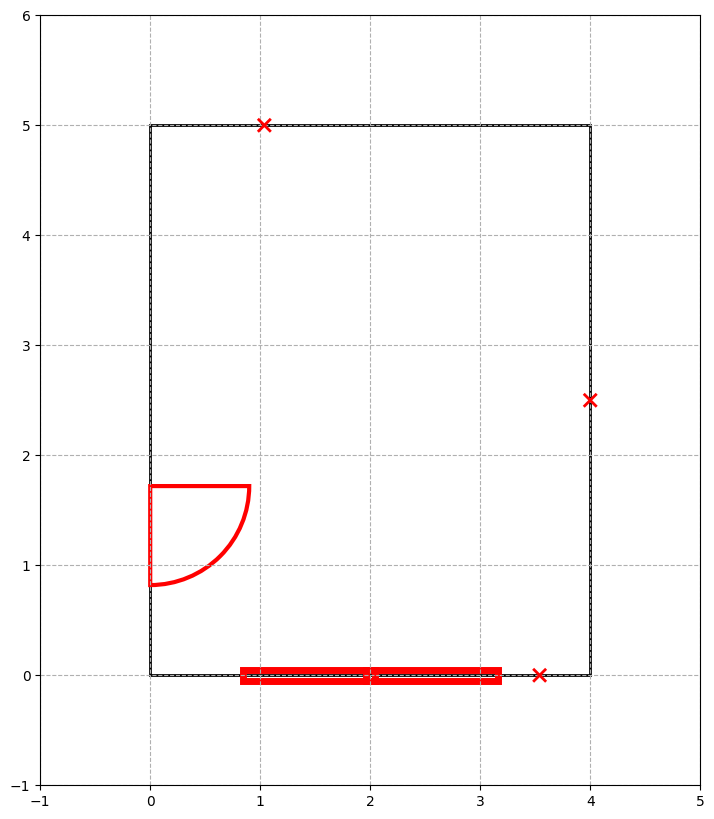

In [83]:
room = create_room(4, 5)
create_fixed_object(room, 'window', 1.2, 0.1, 'south', 0.3)
create_fixed_object(room, 'window', 1.2, 0.1, 'south', 0.7)
create_fixed_object(room, 'door', 0.9, 0.1, 'west', 0.2)
create_fixed_object(room, 'socket', 0.15, 0.1, 'north', 0.25)
create_fixed_object(room, 'socket', 0.15, 0.1, 'east', 0.5)
create_fixed_object(room, 'socket', 0.15, 0.1, 'south', 0.9)

region_setup(room, 'sleeping', 0)
region_setup(room, 'storage', 1)
region_setup(room, 'workspace', 2)

room.draw()

In [84]:
create_moving_object(room, 'bed', 1.6, 2.0, 'sleeping', 0)
create_moving_object(room, 'wardrobe', 1.8, 0.6, 'storage', 1)
create_moving_object(room, 'desk', 1.2, 0.6, 'workspace', 2)

In [85]:
def optimize_primary_objects(positions, room):
    output = 0
    output  += ind_next_to_wall(positions, room, 0)
    output  += ind_next_to_wall(positions, room, 1)
    output  += ind_next_to_wall(positions, room, 2)

    output  += ind_accessible(positions, room, 0, ['left'])
    output  += ind_away_from_fixed_object(positions, room, 0, 'window')
    output  += ind_close_to_fixed_object(positions, room, 0, 'socket')
    output  += ind_accessible(positions, room, 0, ['front'])
    output  += ind_not_block_fixed_object(positions, room, 1, 'window')
    output  += ind_not_block_fixed_object(positions, room, 1, 'door')
    output  += ind_close_to_fixed_object(positions, room, 1, 'socket')
    output  += ind_close_to_fixed_object(positions, room, 2, 'socket')
    output  += ind_not_block_fixed_object(positions, room, 2, 'window')
    output  += io_away_from(positions, room, 0, 2)
    output  += io_away_from(positions, room, 1, 0)
    output  += io_away_from(positions, room, 1, 2)
    output  += io_away_from(positions, room, 2, 1)
    output  += io_away_from(positions, room, 0, 1)

    output += wall_attraction(positions, room)
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    output += 10*balanced(positions, room)
    return output

Iteration: 10 , New best result found. Cost:  9.528257010756978
Iteration: 25 , New best result found. Cost:  7.3358508423137225
Iteration: 151 , New best result found. Cost:  6.6134539340600345
Iteration: 300 , New best result found. Cost:  6.277506892631393


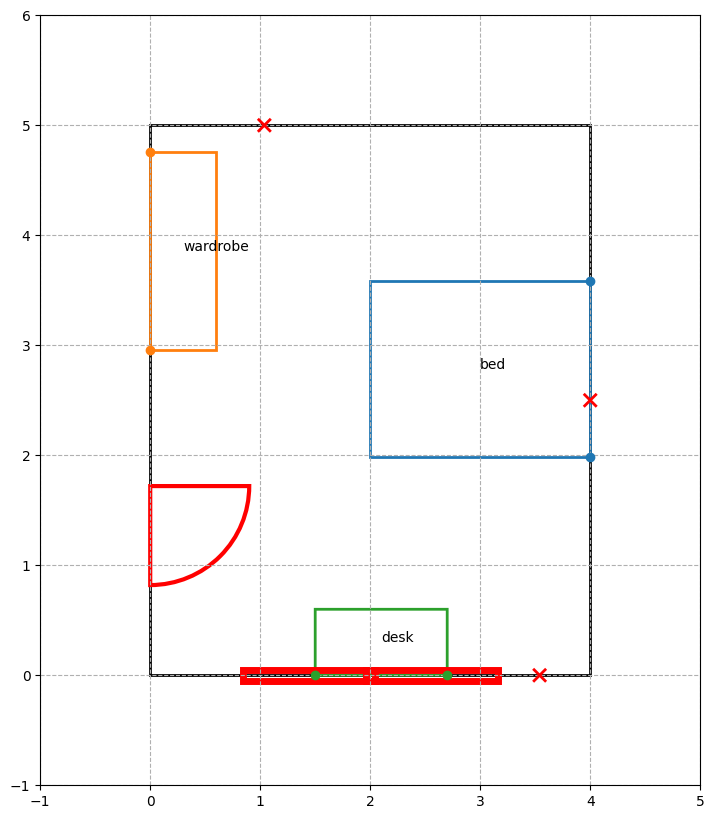

In [87]:
options = {'maxiter': 300, 'ftol': 1e-6}
iters = 0
min_fun = np.Inf
while iters < 300:
    positions = np.zeros((len(room.moving_objects) - len(room.fm_indices)) * 3)
    for i in range(len(room.moving_objects) - len(room.fm_indices)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects, positions, args = (room), method = 'SLSQP', options = options) 
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 0.3 and not in_bounds(res.x, room) > 1e-2:
            min_fun = res.fun
            best_res = res
            print("Iteration:", iters, ", New best result found. Cost: ", min_fun)

for i in range(len(room.fm_indices), len(room.moving_objects)): 
    j = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*j:3*j + 3] 
room.draw() 

for i in range(3):
    room.regions[i].x, room.regions[i].y = room.moving_objects[i].position[0], room.moving_objects[i].position[1]


In [212]:
def io_next_to(positions, room, object1_index, object2_index, side1 = None, side2 = None):
    """ The function next_to ensures that two objects are next to each other in a room. 
        This function should only be used when two objects need to be next to each other, 
        e.g. a chair next to a desk, a bed next to a nightstand, a sofa next to side table. 

        Args:
        room: rectangular Room object
        object1: Object object
        object2: Object object
        side1: optional string, one of 'top' or 'back', 'bottom' or 'front', 'left', 'right', defines which side of object1 to use
        side2: optional string, one of 'top' or 'back', 'bottom' or 'front', 'left', 'right', defines which side of object2 to use
    """
    val = 0

    obj1 = room.moving_objects[object1_index]
    obj2 = room.moving_objects[object2_index]

    x1, y1, theta1 = get_position(positions, room, object1_index)
    x2, y2, theta2 = get_position(positions, room, object2_index)

    cs1 = np.array(corners(x1, y1, theta1, obj1.width, obj1.length)) # TL, TR, BR, BL
    cs2 = np.array(corners(x2, y2, theta2, obj2.width, obj2.length)) # TL, TR, BR, BL

    if side1: 
        if side1 == 'top' or side1 == 'back':
            point1, point2 = cs1[0], cs1[1] # TL, TR
        elif side1 == 'bottom' or side1 == 'front':
            point1, point2 = cs1[2], cs1[3] # BR, BL
        elif side1 == 'left':
            point1, point2 = cs1[0], cs1[3] # TL, BL
        elif side1 == 'right':
            point1, point2 = cs1[1], cs1[2] # TR, BR
        else:
            return io_next_to(positions, room, object1_index, object2_index, side2 = side2)
    if side2: 
        if side2 == 'top' or side2 == 'back':
            point3, point4 = cs2[0], cs2[1]
        elif side2 == 'bottom' or side2 == 'front':
            point3, point4 = cs2[2], cs2[3]
        elif side2 == 'left':
            point3, point4 = cs2[0], cs2[3]
        elif side2 == 'right':
            point3, point4 = cs2[1], cs2[2]
        else:
            return io_next_to(positions, room, object1_index, object2_index, side1 = side1)
        
    if side1 and side2:

        ### if two sides are given, we want the two sides to be parallel, as well as the two objects to be close to each other
        ### Want it to not matter if the centers are close per se, more that the sides are close (perpendicular distance between the two lines?)
        direction1 = np.array([point2[0] - point1[0], point2[1] - point1[1]]) # side1
        direction2 = np.array([point4[0] - point3[0], point4[1] - point3[1]]) # side2

        angle_diff = np.arccos(np.dot(direction1, direction2)/(max(np.linalg.norm(direction1), 1e-6)*max(np.linalg.norm(direction2), 1e-6)))
        val += 2 * np.sin(angle_diff)**2

        if np.linalg.norm(direction1) > np.linalg.norm(direction2):
            point5 = np.array([(point3[0] + point4[0]) / 2, (point3[1] + point4[1]) / 2]) # point on the shorter side
            point6 = np.array([(point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2]) # point on the longer side
            dim_shorter = np.linalg.norm(direction2)
            direction3 = np.array([point5[0] - point1[0], point5[1] - point1[1]])
            direction4 = np.array([point5[0] - point2[0], point5[1] - point2[1]])
            t = np.dot(direction1, direction3)/np.linalg.norm(direction1)
            direction5 = direction1
        else: 
            point5 = np.array([(point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2]) # point on the shorter side
            point6 = np.array([(point3[0] + point4[0]) / 2, (point3[1] + point4[1]) / 2]) # point on the longer side
            dim_shorter = np.linalg.norm(direction1)
            direction3 = np.array([point5[0] - point3[0], point5[1] - point3[1]])
            direction4 = np.array([point5[0] - point4[0], point5[1] - point4[1]])
            t = np.dot(direction2, direction3)/np.linalg.norm(direction2)
            direction5 = direction2
        if t < 0: 
            val += np.linalg.norm(direction3)**2 + (t)**2 + (point5[0] - point6[0])**2 + (point5[1] - point6[1])**2
        elif t > 1: 
            val += np.linalg.norm(direction4)**2 + (t - 1)**2 + (point5[0] - point6[0])**2 + (point5[1] - point6[1])**2
        else: 
            val += (point5[0] - point6[0])**2 + (point5[1] - point6[1])**2
        if np.linalg.norm(t*direction5) < dim_shorter/2: 
            val += 10*(dim_shorter/2 - np.linalg.norm(t*direction5))**2
        if np.linalg.norm((1 - t)*direction5) < dim_shorter/2:
            val += 10*(dim_shorter/2 - np.linalg.norm((1 - t)*direction5))**2
        else: 
            distance = np.linalg.norm(np.cross(direction5, direction3)) / np.linalg.norm(direction5)
            val += distance**2
    
    if side1 and not side2:
        min_side_dist = np.inf
        sides = ['front', 'back', 'left', 'right']
        for i in range(4): 
            side_value = io_next_to(positions, room, object1_index, object2_index, side1 = side1, side2 = sides[i])
            min_side_dist = min(min_side_dist, side_value)
        val += min_side_dist
                
        return val 
    
    if side2 and not side1:     
        min_side_dist = np.inf
        sides = ['front', 'back', 'left', 'right']
        for i in range(4): 
            side_value = io_next_to(positions, room, object1_index, object2_index, side1 = sides[i], side2 = side2)
            min_side_dist = min(min_side_dist, side_value)
        val += min_side_dist

        return val 
    if not side2 and not side1: 
        ### If no sides are given, we want the two objects to be close to each other as possible from any direction
        ### Want the distance between the two objects to be minimized but also to not be overlapping 

        distance = np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2]))
        val += distance**2

    return 2*val 

In [10]:
import string 
import random

style = """
Based on the dimensions provided (4m x 5m) and the list of objects, we'll create a cohesive and aesthetically pleasing bedroom design with thoughtful selections for wall treatments, flooring, and each object.

### Walls:
- **Colour:** A soft, neutral palette such as light grey or warm beige to provide a serene and relaxing environment.
- **Treatment:** High-quality paint for a clean, modern look. Avoid wallpaper to maintain simplicity and versatility.

### Floor:
- **Material:** Hardwood for durability and elegance.
- **Colour:** A medium oak finish that provides warmth and complements the neutral wall colour.

---

### Objects:

1. **Bed:**
   - **Size:** Queen-sized for proportionate fitting in the room.
   - **Colour:** Dark walnut frame with a soft grey upholstered headboard.
   - **Style:** Modern with clean lines and minimalistic design.

2. **Wardrobe:**
   - **Colour:** White with sleek silver handles.
   - **Style:** Scandinavian-inspired with a focus on functionality and simplicity.

3. **Desk:**
   - **Colour:** Light wood top with white metal legs.
   - **Style:** Minimalist, providing a clutter-free workspace.

4. **Nightstands (2):**
   - **Colour:** Matching the bed frame, dark walnut.
   - **Style:** Modern with a single drawer for a clean appearance.

5. **Dresser:**
   - **Colour:** White to match the wardrobe.
   - **Style:** Contemporary with straight lines and silver handles.

6. **Desk Chair:**
   - **Colour:** Light grey fabric with a chrome base.
   - **Style:** Ergonomic and modern.

7. **Lamp (2):**
   - **Colour:** White ceramic base with a light grey shade.
   - **Style:** Elegant and simple, fitting well with nightstands and dresser.

8. **Painting:**
   - **Colour:** A modern abstract piece with predominant shades of grey, blue, and white to add a pop of colour.
   - **Style:** Framed in a sleek black frame for a gallery-quality look.

9. **Mirror:**
   - **Colour:** Frameless or with a thin silver frame.
   - **Style:** Large and full-length for functionality and room enlargement effect.

10. **Organizer:**
    - **Colour:** Soft beige fabric bins with white wooden frame.
    - **Style:** Practical and minimalistic.

11. **Monitor:**
    - **Colour:** Black.
    - **Style:** Sleek and modern, with a small footprint on the desk.

12. **Chandelier:**
    - **Colour:** Polished chrome with clear crystal accents.
    - **Style:** Modern and elegant, adding a touch of luxury to the room.

13. **Rug:**
    - **Colour:** Light grey with subtle geometric patterns in white.
    - **Style:** Plush and cozy, placed under the bed extending slightly beyond it.

---

### Cohesion and Harmony:
The selections ensure a cohesive design that blends modern, minimalistic, and Scandinavian elements. The soft neutral walls and medium oak flooring create a warm and balanced foundation. Each piece of furniture and accessory has been chosen for its simplicity, elegance, and ability to create a tranquil, aesthetically pleasing bedroom
"""


dictionary = {}
dictionary['prompt'] = "A bedroom that is 4m x 5m."
dictionary['room_width'] = 4
dictionary['room_length'] = 5
dictionary['bed'] = {'position': [2.99908829, 2.25479268, 1.5695796], 'width': 1.5, 'length': 2.0}
dictionary['wardrobe'] = {'position': [3.42901209, 4.21707574, 2.12461495], 'width': 1.2, 'length': 0.6}
dictionary['desk'] = {'position': [0.30000861, 2.81002244, 4.71240767], 'width': 1.2, 'length': 0.6}
dictionary['nightstand'] = {'position': [3.79991191, 1.25175276, 7.85434872], 'width': 0.5, 'length': 0.4}
dictionary['nightstand0'] = {'position': [3.80008485, 3.25413099, 1.57114411], 'width': 0.5, 'length': 0.4}
dictionary['dresser'] = {'position': [1.30172319, 4.75,       3.14159263], 'width': 1, 'length': 0.5}
dictionary['desk chair'] = {'position': [0.91412479, 2.95398787, 1.74974214], 'width': 0.6, 'length': 0.6}
dictionary['door'] = {'position': (0, 1.31, 4.71238898038469), 'width': 0.9, 'length': 0.1}
dictionary['window'] = {'position': (1.7199999999999998, 0, 0), 'width': 1.2, 'length': 0.1}
dictionary['window1'] = {'position': (4, 2.88, 1.5707963267948966), 'width': 1.2, 'length': 0.1}
dictionary['socket'] = {'position': (1.24, 5, 3.141592653589793), 'width': 0.2, 'length': 0.1}
dictionary['socket2'] = {'position': (0, 2.5, 4.71238898038469), 'width': 0.2, 'length': 0.1}
dictionary['socket3'] = {'position': (4, 1.06, 1.5707963267948966), 'width': 0.2, 'length': 0.1}
dictionary['lamp'] = {'position': [3.80412864, 1.23225814, 7.85095846], 'width': 0.3, 'length': 0.3}
dictionary['lamp4'] = {'position': [3.78080645, 3.28990829, 1.55808384], 'width': 0.3, 'length': 0.3}
dictionary['painting'] = {'position': [3.95018539, 4.03000554, 1.57090923], 'width': 1, 'length': 0.1}
dictionary['mirror'] = {'position': [0.0517405, 4.41183166, 4.71020655], 'width': 1.2, 'length': 0.1}
dictionary['organizer'] = {'position': [0.12629494, 2.96523696, 4.59031376], 'width': 0.4, 'length': 0.2}
dictionary['monitor'] = {'position': [0.3809275, 2.66377354, 4.76536102], 'width': 0.5, 'length': 0.2}
dictionary['chandelier'] = {'position': [1.95436299, 2.49507894, 4.70553326], 'width': 0.8, 'length': 0.8}
dictionary['rug'] = {'position': [2.11805036, 2.10440163, 97.37731695], 'width': 2, 'length': 3}
dictionary['style'] = style

## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/45_bedroom.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")

In [11]:
style = """
### Room Overview
Let's create a cohesive and stylish living room based on your provided objects, keeping the design elements in harmony with one another.

### Walls
#### Color and Treatment
- **Walls**: Soft dove gray paint. This neutral color will create a calming and sophisticated backdrop that complements the array of furnishings and decor while allowing other elements to stand out.
- **Accent Wall**: Wallpaper with a subtle geometric pattern in a tone-on-tone dove gray to add a touch of modern elegance without overwhelming the room.

### Floor
#### Material and Color
- **Material**: Light oak hardwood.
- **Color**: Natural light oak with a matte finish. This will enhance the sense of space and brightness in the room while providing a warm and inviting foundation.

### Objects and Their Descriptions
#### Sofa
- **Color**: Slate gray.
- **Style**: Modern with clean lines and low-profile design.
- **Material**: Upholstered in a soft, durable fabric.

#### TV Stand
- **Color**: Charcoal black with hints of brushed steel.
- **Style**: Contemporary with sleek, minimalist lines.
- **Material**: Lacquered wood with steel accents.

#### Coffee Table
- **Color**: Natural walnut.
- **Style**: Mid-century modern with tapered legs and a simple silhouette.
- **Material**: Solid walnut wood.

#### Armchair
- **Color**: Teal.
- **Style**: Transitional with a balance of classic and contemporary elements.
- **Material**: Velvet upholstery with dark wooden legs.

#### Bookshelf
- **Color**: Espresso brown.
- **Style**: Industrial with black metal frame and wooden shelves.
- **Material**: Metal frame with wooden shelves.

#### Rug
- **Color**: Ivory with subtle teal and gray geometric patterns.
- **Style**: Contemporary.
- **Material**: Wool blend for softness and durability.

#### Painting
- **Color**: Predominantly blues and grays with splashes of vibrant teal.
- **Style**: Abstract.
- **Material**: Acrylic on canvas in a sleek black frame.

#### Television
- **Color**: Black.
- **Style**: Modern, slim flat-screen.
- **Material**: Glass and metal.

#### Sculpture
- **Color**: Brushed stainless steel.
- **Style**: Modern, abstract.
- **Material**: Metal.

#### Vase
- **Color**: Teal with a glossy finish.
- **Style**: Modern.
- **Material**: Ceramic.

#### Tray
- **Color**: Matte black.
- **Style**: Minimalist.
- **Material**: Metal.

#### Frame
- **Color**: Black.
- **Style**: Simple and modern.
- **Material**: Wood with a matte finish.

#### Plant
- **Color**: Greenery with a white ceramic pot.
- **Style**: Contemporary.
- **Material**: Live plant with ceramic pot.

#### Pillow
- **Color**: Soft shades of teal and gray.
- **Style**: Modern with subtle patterns.
- **Material**: Cotton blend.

#### Chandelier
- **Color**: Black iron with glass accents.
- **Style**: Modern-industrial.
- **Material**: Iron and glass.

### Summary
By using a dove gray paint for the walls with an accent wallpaper, and light oak for the floor, this room establishes a neutral and versatile base. The chosen objects follow a cohesive color palette dominated by gray, teal, and natural wood tones, with accents of black and stainless steel to add a modern feel. The mix of contemporary, modern, mid-century modern, and industrial styles blend harmoniously, creating a stylish and comfortable living space.
"""


dictionary = {}
dictionary['prompt'] = "A living room that is 4x4."
dictionary['room_width'] = 4
dictionary['room_length'] = 4
dictionary['sofa'] = {'position': [1.92434764, 0.45000005, 1.51672115], 'width': 2, 'length': 0.9}
dictionary['tv stand'] = {'position': [2.88077679, 3.80000167, 3.14159024], 'width': 1.6, 'length': 0.4}
dictionary['coffee table'] = {'position': [0.60250854, 1.82678379, -1.93790387], 'width': 1, 'length': 0.6}
dictionary['armchair'] = {'position': [3.60018664, 1.33334253, 1.57005126], 'width': 0.8, 'length': 0.8}
dictionary['bookshelf'] = {'position': [3.85000013, 2.13326828, 1.57079642], 'width': 0.8, 'length': 0.3}
dictionary['door'] = {'position': (1.12, 4, 3.141592653589793), 'width': 0.8, 'length': 0.1}
dictionary['window'] = {'position': (4, 1.4, 1.5707963267948966), 'width': 1, 'length': 0.1}
dictionary['window1'] = {'position': (0, 2.5999999999999996, 4.71238898038469), 'width': 1, 'length': 0.1}
dictionary['socket'] = {'position': (2.0, 0, 0), 'width': 0.2, 'length': 0.1}
dictionary['socket2'] = {'position': (4, 3.14, 1.5707963267948966), 'width': 0.2, 'length': 0.1}
dictionary['rug'] = {'position': [1.92435958, 0.74970027, 94.24777962], 'width': 2.5, 'length': 1.5}
dictionary['painting'] = {'position': [1.92434423, 0.04995485, 6.09849141], 'width': 1.2, 'length': 0.1}
dictionary['television'] = {'position': [2.89634663, 3.94999964, 3.14159251], 'width': 1.4, 'length': 0.1}
dictionary['sculpture'] = {'position': [2.48079464, 3.85004962, 1.57079589], 'width': 0.3, 'length': 0.3}
dictionary['vase'] = {'position': [1.72824858, 1.32975734, 1.57079848], 'width': 0.2, 'length': 0.2}
dictionary['tray'] = {'position': [0.57266999, 2.10609837, 6.28271787], 'width': 0.3, 'length': 0.3}
dictionary['frame'] = {'position': [3.84980779, 2.23243752, 1.57099434], 'width': 0.2, 'length': 0.1}
dictionary['plant'] = {'position': [3.85008381, 2.03243377, 1.57091821], 'width': 0.2, 'length': 0.2}
dictionary['pillow'] = {'position': [1.62985213, 3.58618082, 3.14159133], 'width': 0.5, 'length': 0.5}
dictionary['chandelier'] = {'position': [1.99995042, 2.00002114, 6.28318627], 'width': 1, 'length': 1}
dictionary['style'] = style

## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/44_living.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")

In [12]:
style = """
### Room Details
**Walls:** The walls are a calming shade of sage green paint. This color is both earthy and relaxing, lending a tranquil yet vibrant atmosphere to the boho dining room.

**Floor:** The floor is made of light, natural oak wood with a smooth matte finish, adding warmth and grounding the space without overpowering the other elements in the room.

### Object Details:

1. **Rectangular Dining Table:**
   - **Colour:** Natural wood finish
   - **Style:** Rustic with a minimalist design
   - **Description:** The rectangular dining table serves as the central piece of the room. Its natural wood finish complements the light oak floor and enhances the earthy boho vibe.

2. **Large Indoor Plant:**
   - **Colour:** Deep green leaves
   - **Style:** A large monstera in a woven seagrass basket
   - **Description:** This plant adds a touch of lush greenery, reinforcing the natural, organic feel of the room.

3. **Armchair:**
   - **Colour:** Soft cream upholstery with wooden legs
   - **Style:** Mid-century modern with a boho twist
   - **Description:** The armchair provides an extra seating option or a cozy spot to relax. The soft cream color ties in well with the natural wood tones and the green hues of the room.

4. **Dining Chairs (4):**
   - **Colour:** Mix of natural wood and white
   - **Style:** Rustic with woven rattan seats
   - **Description:** These chairs coordinate with the dining table and add texture to the room with their woven seats.

5. **Plant Stand:**
   - **Colour:** Black metal
   - **Style:** Industrial chic
   - **Description:** The black metal plant stand brings a subtle contrast and elevates smaller plants to eye level, adding visual interest.

6. **Small Bookshelf:**
   - **Colour:** Dark-stained wood
   - **Style:** Vintage boho
   - **Description:** The small bookshelf is home to books, decorative items, and plants. Its dark stain is a nice counterbalance to the lighter wood tones in the room.

7. **Side Table:**
   - **Colour:** Natural bamboo
   - **Style:** Boho eclectic
   - **Description:** Placed near the armchair, the side table offers a convenient spot for a lamp and a couple of books, and its bamboo material adds to the bohemian aesthetic.

8. **Chandelier:**
   - **Colour:** Black wrought iron with warm white bulbs
   - **Style:** Vintage bohemian with an industrial edge
   - **Description:** Hanging over the dining table, the chandelier provides ambient lighting and ties together the rustic and boho elements of the room.

9. **Table Runner:**
   - **Colour:** Earthy tones with geometric patterns
   - **Style:** Bohemian chic
   - **Description:** This table runner adds a pop of pattern and color to the dining table, enhancing the overall boho vibe.

10. **Wall Art:**
    - **Colour:** Mixed warm tones, including reds, oranges, and earthy browns
    - **Style:** Abstract bohemian
    - **Description:** The wall art introduces vibrant color and artistic flair to the room, acting as a focal point on one of the green-painted walls.

11. **Hanging Planters:**
    - **Colour:** White ceramic with macramé hangers
    - **Style:** Boho and minimalist
    - **Description:** These planters hang near the windows, bringing in more greenery and texture through their macramé hangers.

12. **Plant Pot:**
    - **Colour:** Terracotta
    - **Style:** Classic bohemian
    - **Description:** Placed on the plant stand, the terracotta pot adds a warm, earthy element to the room.

13. **Reading Lamp:**
    - **Colour:** Brass with a white shade
    - **Style:** Vintage-inspired
    - **Description:** Positioned next to the armchair, the reading lamp provides focused light and a touch of vintage elegance.

14. **Book:**
    - **Colour:** Various natural shades
    - **Style:** Eclectic collection
    - **Description:** Arranged on the bookshelf, the book covers display a mix of muted and earthy tones, fitting perfectly with the room’s color palette.

15. **Wall Sconce:**
    - **Colour:** Brass
    - **Style:** Retro bohemian
    - **Description:** Installed on either side of the wall art, the wall sconces provide accent lighting with a vintage charm.

16. **Area Rug:**
    - **Colour:** Neutral base with rich, warm patterns
    - **Style:** Boho-chic
    - **Description:** The area rug anchors the dining table, adding comfort underfoot and cohesion to the room’s design elements through its colorful, intricate patterns.

Overall, each object in the room maintains a harmonious balance of natural materials, earthy tones, and boho aesthetics, creating a cohesive and inviting dining space.
"""

dictionary = {}
dictionary['prompt'] = "A small green boho dining room."
dictionary['room_width'] = 4
dictionary['room_length'] = 5
dictionary['rectangular dining table'] = {'position': [2.51042458, 2.79741786, 1.5705776], 'width': 1.5, 'length': 2.0}
dictionary['large indoor plant'] = {'position': [0.24587333, 4.35695157, 3.22656595], 'width': 0.5, 'length': 0.5}
dictionary['armchair'] = {'position': [0.39613517, 0.39557378, -0.00175959], 'width': 0.8, 'length': 0.8}
dictionary['dining chair'] = {'position': [1.24871249, 2.85140877, 10.82262946], 'width': 0.5, 'length': 0.5}
dictionary['dining chair0'] = {'position': [2.81082143, 3.90405269, 3.11708849], 'width': 0.5, 'length': 0.5}
dictionary['dining chair1'] = {'position': [2.92346272, 1.77237575, 6.36016765], 'width': 0.5, 'length': 0.5}
dictionary['dining chair2'] = {'position': [2.09813872, 1.78053305, -0.06530327], 'width': 0.5, 'length': 0.5}
dictionary['plant stand'] = {'position': [0.78465421, 4.8248074, 4.67919163], 'width': 0.4, 'length': 0.4}
dictionary['small bookshelf'] = {'position': [1.19594595, 0.15005973, -0.00014593], 'width': 0.8, 'length': 0.3}
dictionary['side table'] = {'position': [0.55073905, 1.32857237, 2.90803306], 'width': 0.5, 'length': 0.5}
dictionary['window'] = {'position': (1.75, 5, 3.141592653589793), 'width': 1.5, 'length': 0.1}
dictionary['window1'] = {'position': (2.5, 5, 3.141592653589793), 'width': 1.5, 'length': 0.1}
dictionary['door'] = {'position': (4, 0.42000000000000004, 1.5707963267948966), 'width': 0.8, 'length': 0.1}
dictionary['socket'] = {'position': (1.24, 0, 0), 'width': 0.2, 'length': 0.1}
dictionary['socket2'] = {'position': (0, 2.5, 4.71238898038469), 'width': 0.2, 'length': 0.1}
dictionary['socket3'] = {'position': (4, 2.98, 1.5707963267948966), 'width': 0.2, 'length': 0.1}
dictionary['chandelier'] = {'position': [1.95431482, 2.79830116, 1.57079722], 'width': 0.8, 'length': 0.8}
dictionary['table runner'] = {'position': [2.51042541, 2.79742004, 1.57075282], 'width': 0.3, 'length': 2.0}
dictionary['wall art'] = {'position': [3.94797448, 2.79830116, 1.57079722], 'width': 0.8, 'length': 0.1}
dictionary['hanging planters'] = {'position': [0.24587546, 4.35695156, 9.42477787], 'width': 0.3, 'length': 0.3}
dictionary['plant pot'] = {'position': [3.81529686, 4.03787266, 9.42477797], 'width': 0.3, 'length': 0.3}
dictionary['reading lamp'] = {'position': [0.55073886, 1.32857235, 3.09466059], 'width': 0.2, 'length': 0.2}
dictionary['book'] = {'position': [1.19594819, 0.15054735, -0.0000291493389], 'width': 0.2, 'length': 0.3}
dictionary['wall sconce'] = {'position': [0.395431482, 0.0499827922, -7.31534263e-09], 'width': 0.2, 'length': 0.1}
dictionary['area rug'] = {'position': [2.50001042, 2.79741902, 7.85398162], 'width': 2, 'length': 3}

dictionary['style'] = style
## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/boho_dining.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")


In [13]:
style = """
### Office Description and Design Details

#### Walls:
- **Colour**: Soft, muted sage green
- **Finish**: Matte paint
- **Reasoning**: The sage green provides a calming environment conducive to creativity and aligns well with the Fantasy book theme, creating a magical, serene ambiance.

#### Floor:
- **Material**: Hardwood
- **Colour**: Medium walnut brown
- **Finish**: Semi-gloss
- **Reasoning**: The medium walnut brown offers a warm, inviting contrast to the soft green walls, making the room feel cozy and sophisticated.

### Object Descriptions:

1. **Desk**
   - **Colour**: Dark mahogany
   - **Style**: Classic, with ornate carvings and brass handles.
   - **Reasoning**: A dark mahogany desk provides a rich and timeless look, anchoring the room in a classic style suitable for a writer's space.

2. **Armchair**
   - **Colour**: Deep forest green
   - **Material**: Velvet upholstery
   - **Style**: Vintage, with wooden legs and tufted back.
   - **Reasoning**: The deep forest green complements the wall colour while the velvet texture adds a luxurious, fantasy-like element.

3. **Bookshelf**
   - **Colour**: Dark mahogany
   - **Material**: Wood
   - **Style**: Traditional, matching the desk.
   - **Reasoning**: Cohesive with the desk, providing a stately look that fits a writer's office.

4. **Desk Chair**
   - **Colour**: Dark brown leather
   - **Style**: Executive, with polished wooden arms and base.
   - **Reasoning**: The dark brown leather provides comfort and sophistication, complementing the desk and bookshelf.

5. **Small Filing Cabinet**
   - **Colour**: Dark mahogany
   - **Material**: Wood
   - **Style**: Traditional, matching the desk and bookshelf.
   - **Reasoning**: This keeps the room cohesive while providing necessary storage.

6. **Side Table**
   - **Colour**: Deep forest green
   - **Material**: Wood with a painted finish.
   - **Style**: Simple and elegant, with minimalistic lines.
   - **Reasoning**: Matches the armchair for a coherent look.

7. **Additional Bookcase**
   - **Colour**: Dark mahogany
   - **Material**: Wood
   - **Style**: Traditional, matching the desk and primary bookshelf.
   - **Reasoning**: Essential for ample book storage and maintains design consistency.

8. **Laptop**
   - **Colour**: Silver
   - **Style**: Modern, with sleek lines.
   - **Reasoning**: The silver adds a contemporary touch, ensuring the space is functional and up-to-date.

9. **Desk Lamp**
   - **Colour**: Bronze with a cream shade
   - **Style**: Vintage, with an adjustable arm.
   - **Reasoning**: Complements the dark wood furniture and adds to the classic writer's room aesthetic.

10. **Corkboard**
    - **Colour**: Natural cork with a dark mahogany frame
    - **Style**: Simple and functional.
    - **Reasoning**: Fits seamlessly with the wood elements in the room.

11. **Quote**
    - **Colour**: Black text on a cream background
    - **Frame**: Dark mahogany
    - **Style**: Elegant script.
    - **Reasoning**: Inspirational and stylish, perfect for a writer’s space.

12. **Table Lamp**
    - **Colour**: Bronze with a cream shade
    - **Style**: Traditional, matching the desk lamp.
    - **Reasoning**: Consistent with the lighting choices and adds warmth.

13. **Plant**
    - **Type**: Potted fern
    - **Pot**: Dark green ceramic
    - **Reasoning**: Adds a touch of nature and liveliness, with the pot complementing the room’s colour palette.

14. **Artwork**
    - **Colour**: Various (fantasy-themed with rich, earthy tones)
    - **Frame**: Dark mahogany
    - **Style**: Intricate and detailed, fitting the Fantasy theme.
    - **Reasoning**: Artistic renditions of fantasy landscapes or characters enhance the theme and inspire creativity.

15. **Bookends**
    - **Colour**: Bronze
    - **Style**: Dragon-shaped, intricate details.
    - **Reasoning**: A nod to the Fantasy genre, they are both practical and thematic.

16. **Globe**
    - **Colour**: Antique (muted colours with gold accents)
    - **Style**: Vintage, with wooden

17. **Rug**
    - **Colour**: Cream and sage green
    - **Style**: Persian-inspired, with rich colours and intricate patterns.

18. **Chandelier**
    - **Colour**: Bronze with crystal accents
    - **Style**: Classic, with ornate details.
"""

dictionary = {}
dictionary['prompt'] = "An office for a bestselling writer in New York who likes to write Fantasy books."
dictionary['room_width'] = 4
dictionary['room_length'] = 5
dictionary['desk'] = {'position': [2.49377523, 0.52754578, 6.25528297], 'width': 2, 'length': 1.5}
dictionary['armchair'] = {'position': [1.80797788, 4.57850556, 3.18450962], 'width': 1, 'length': 0.8}
dictionary['bookshelf'] = {'position': [0.13669401, 3.88046608, 4.69426186], 'width': 1, 'length': 0.3}
dictionary['desk chair'] = {'position': [2.6102624, 1.37329247, 3.1731128], 'width': 0.6, 'length': 0.6}
dictionary['small filing cabinet'] = {'position': [3.68619674, 0.238762, 6.25532212], 'width': 0.4, 'length': 0.5}
dictionary['side table'] = {'position': [3.65247773, 4.46015406, 2.95532382], 'width': 0.5, 'length': 0.5}
dictionary['additional bookcase'] = {'position': [0.15000001, 2.37795721, 4.712389], 'width': 1, 'length': 0.3}
dictionary['laptop'] = {'position': [2.48172721, 0.52915251, 6.27386633], 'width': 0.4, 'length': 0.3}
dictionary['desk lamp'] = {'position': [1.99077105, 0.29368739, 3.1438683], 'width': 0.2, 'length': 0.2}
dictionary['corkboard'] = {'position': [3.94909992, 0.49007021, 1.56664429], 'width': 1, 'length': 0.1}
dictionary['quote'] = {'position': [3.84847143, 0.33896023, 1.56664515], 'width': 0.5, 'length': 0.1}
dictionary['table lamp'] = {'position': [3.62984617, 4.57118948, 3.13255407], 'width': 0.2, 'length': 0.2}
dictionary['plant'] = {'position': [3.65479072, 4.36665443, 3.1316734], 'width': 0.2, 'length': 0.2}
dictionary['artwork'] = {'position': [3.94417861, 4.50977826, 1.57505653], 'width': 1, 'length': 0.1}
dictionary['bookends'] = {'position': [0.10131225, 3.88551063, 4.70799929], 'width': 0.2, 'length': 0.2}
dictionary['globe'] = {'position': [0.1551974, 2.39056181, 4.71084047], 'width': 0.3, 'length': 0.3}
dictionary['rug'] = {'position': [1.90050023, 1.49935473, 163.36424821], 'width': 2, 'length': 3}
dictionary['chandelier'] = {'position': [2.00898848, 2.50559756, 9.42407544], 'width': 1, 'length': 1}
dictionary['window'] = {'position': (1.375, 5, 3.141592653589793), 'width': 1.5, 'length': 0.1}
dictionary['window1'] = {'position': (2.625, 5, 3.141592653589793), 'width': 1.5, 'length': 0.1}
dictionary['door'] = {'position': (4, 2.05, 1.5707963267948966), 'width': 0.9, 'length': 0.1}
dictionary['socket'] = {'position': (0, 1.0150000000000001, 4.71238898038469), 'width': 0.05, 'length': 0.05}
dictionary['socket2'] = {'position': (2.79, 0, 0), 'width': 0.05, 'length': 0.05}
dictionary['socket3'] = {'position': (4, 1.0150000000000001, 1.5707963267948966), 'width': 0.05, 'length': 0.05}
dictionary['style'] = style

## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/writer_office.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")
    


In [15]:
style = """
### Room and Wall Description

The small home gym, measuring 4m x 5m, should have a welcoming yet energetic ambiance. To achieve this, let's use paint on the walls. Painting is durable and easier to clean compared to wallpaper, which is suitable for an environment where activities may cause the walls to get scuffed.

#### Wall Color
- **Paint Color:** Soft, neutral grey with a slight blue undertone. This color will add calmness, help make the room feel open, and serve as a perfect backdrop for the colorful gym equipment.

### Floor Material and Color

- **Material:** Rubber flooring, ideal for a gym as it provides cushioning, is non-slip, and can handle impact from weights.
- **Color:** Black with a speckled pattern (mixes of white, grey and blue speckled accents). This not only hides dirt well but also complements the grey walls.

### Object Descriptions

1. **Treadmill**
   - **Color**: Black and graphite grey
   - **Style**: Modern with a sleek design
   - **Details**: Digital display screen with blue backlight, handrails with soft black neoprene covering.

2. **Adjustable Dumbbell Set**
   - **Color**: Black handles, red adjustment dials, silver weights
   - **Style**: Contemporary and functional
   - **Details**: Stored on a dark grey compact rack to save space when not in use.

3. **Yoga Ball**
   - **Color**: Navy blue
   - **Style**: Matte finish
   - **Details**: Textured surface for grip, anti-burst material.

4. **Stationary Bike**
   - **Color**: Black frame, blue and grey accents
   - **Style**: Ergonomic with a streamlined look
   - **Details**: Adjustable seat, integrated LCD display with grey buttons.

5. **Resistance Bands Set**
   - **Color**: Multicolored (each band for different resistance levels)
   - **Style**: Simple and elastic with black handles
   - **Details**: Comes with a black drawstring storage bag.

6. **Kettlebell Set**
   - **Color**: Black with color-coded handles (Green, Blue, Red, Yellow for different weights)
   - **Style**: Solid and functional
   - **Details**: Matte texture with weight labels in contrasting white.

7. **Yoga Mat**
   - **Color**: Dark grey
   - **Style**: Non-slip surface with a subtle geometric pattern
   - **Details**: Extra-thick for added cushioning.

8. **Foam Roller**
   - **Color**: Charcoal grey
   - **Style**: Textured surface for deep tissue massage
   - **Details**: High-density foam construction.

9. **TV**
   - **Color**: Black
   - **Style**: Slim, wall-mounted
   - **Details**: Positioned at eye level for easy viewing during workouts.

10. **Poster**
    - **Color**: Motivational poster with a mix of navy blue and white text
    - **Style**: Inspirational quote in a modern font
    - **Details**: Framed in black to add a polished touch.

11. **Mirror**
    - **Color**: Silver frame
    - **Style**: Full-length, rectangular
    - **Details**: Positioned to reflect natural light and make the space feel larger.

12. **Speaker**
    - **Color**: Black
    - **Style**: Compact wireless with a sleek design
    - **Details**: Can be placed on a shelf or mounted on the wall for optimal sound distribution.

13. **Clock**
    - **Color**: White face with black numbers, silver frame
    - **Style**: Simple, modern, and easy to read
    - **Details**: Wall-mounted, positioned for clear visibility.

14. **Light**
    - **Color**: Matte silver
    - **Style**: LED overhead lights with a slim profile
    - **Details**: Provides bright, even illumination throughout the room.

15. **Hooks**
    - **Color**: Brushed nickel
    - **Style**: Modern and functional
    - **Details**: Mounted on the wall for storing resistance bands and other small equipment.

### Conclusion

This setup creates a cohesive, visually appealing, and functional home gym. The neutral base colors with subtle color accents from equipment will ensure the space feels both calming and motivating, enhancing the overall workout experience.
"""
dictionary = {}
dictionary['prompt'] = "A small home gym."
dictionary['room_width'] = 4
dictionary['room_length'] = 5
dictionary['treadmill'] = {'position': [0.85919535, 1.89873744, 4.89419385], 'width': 0.8, 'length': 1.6}
dictionary['adjustable dumbbell set'] = {'position': [3.86560726, 4.76316772, 1.56898601], 'width': 0.5, 'length': 0.3}
dictionary['yoga ball'] = {'position': [2.07649724, 2.81570967, 4.64717497], 'width': 0.5, 'length': 0.5}
dictionary['stationary bike'] = {'position': [3.22750631, 0.23288754, 1.57100398], 'width': 0.5, 'length': 1}
dictionary['resistance bands set'] = {'position': [1.86387369, 4.69721885, 3.14796367], 'width': 0.6, 'length': 0.6}
dictionary['kettlebell set'] = {'position': [3.84972604, 3.71668495, 1.57077282], 'width': 0.6, 'length': 0.3}
dictionary['yoga mat'] = {'position': [0.93343135, 4.05000015, 3.13403096], 'width': 0.6, 'length': 1.8}
dictionary['foam roller'] = {'position': [1.30844153, 4.04591741, 6.27574151], 'width': 0.15, 'length': 0.5}
dictionary['tv'] = {'position': [3.84999999, 2.5, 1.57079633], 'width': 0.5, 'length': 0.1}
dictionary['poster'] = {'position': [0.04999996, 1.79951857, 4.71239799], 'width': 0.6, 'length': 0.1}
dictionary['mirror'] = {'position': [0.05267035, 4.05060104, 4.71237929], 'width': 1, 'length': 0.1}
dictionary['speaker'] = {'position': [0.61457627, 4.54241564, 4.71238794], 'width': 0.1, 'length': 0.1}
dictionary['clock'] = {'position': [3.22755969, 0.05061338, 0.00000283], 'width': 0.3, 'length': 0.1}
dictionary['light'] = {'position': [2.00000749, 2.50007253, 10.99557771], 'width': 1, 'length': 0.1}
dictionary['hooks'] = {'position': [0.04990127, 0.99032271, 4.71258645], 'width': 1, 'length': 0.1}
dictionary['window'] = {'position': (1.25, 5, 3.141592653589793), 'width': 1.5, 'length': 0.1}
dictionary['window1'] = {'position': (4, 2.5, 1.5707963267948966), 'width': 1.5, 'length': 0.1}
dictionary['door'] = {'position': (0.30000000000000004, 0, 0), 'width': 1, 'length': 0.1}
dictionary['socket'] = {'position': (0, 1.2750000000000001, 4.71238898038469), 'width': 0.1, 'length': 0.1}
dictionary['socket2'] = {'position': (3.17, 0, 0), 'width': 0.1, 'length': 0.1}
dictionary['socket3'] = {'position': (4, 1.52, 1.5707963267948966), 'width': 0.1, 'length': 0.1}
dictionary['style'] = style

## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/home_gym.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")

In [16]:
style = """
Certainly! Given the described room and the objects within it, we can create a cohesive and aesthetically pleasing setup.

### Walls:
**Colour:** Soft pastel pink.
**Type:** Paint.
**Reasoning:** Soft pastel pink is a calming and pleasant colour often liked by young girls. It also provides a neutral backdrop for her paintings and adds a touch of warmth and creativity to the room.

### Floor:
**Material:** Light oak wood.
**Colour:** Warm, natural light oak.
**Reasoning:** The light oak provides a warm, natural feel that complements the pastel walls and creates a clean, chic look suitable for a young girl's bedroom. It's durable and easy to clean, ideal for an active, creative environment.

### Objects:

1. **Easel:**
   - **Colour:** White.
   - **Style:** Minimalist wood with a simple design.
   - **Reasoning:** A white easel will blend seamlessly with the room's soft hues and provide a clean slate for the art.

2. **Bed:**
   - **Colour:** Soft lavender with a white frame.
   - **Style:** Modern with a touch of vintage, featuring a tufted headboard.
   - **Reasoning:** Lavender is soothing and coordinates well with pink walls. The white frame ties in with the furniture theme.

3. **Wardrobe:**
   - **Colour:** White with pastel pink accents.
   - **Style:** Classic with moulded panels and gentle curves.
   - **Reasoning:** Adding pastel pink accents on the wardrobe doors creates cohesion with the walls.

4. **Small Table:**
   - **Colour:** Light oak.
   - **Style:** Contemporary.
   - **Reasoning:** Matches the flooring, tying the elements of the room together.

5. **Stool:**
   - **Colour:** Soft grey.
   - **Style:** Retro-inspired with a cushioned seat.
   - **Reasoning:** The grey introduces another neutral tone, adding balance and contrast without overpowering the room.

6. **Nightstand:**
   - **Colour:** White.
   - **Style:** Simple, with a single drawer and a bottom shelf.
   - **Reasoning:** Matches the bed frame and wardrobe, enhancing the cohesiveness of the room.

7. **Bookshelf:**
   - **Colour:** White.
   - **Style:** Open shelving unit with a clean and straightforward design.
   - **Reasoning:** Keeps the focus on the books and decorative items while coordinating with other white furniture.

8. **Storage Ottoman:**
   - **Colour:** Soft lavender.
   - **Style:** Upholstered with a tufted top.
   - **Reasoning:** Matches the bed, provides additional storage, and enhances the room's colour scheme.

9. **Painting:**
   - **Colour:** Varied (dependent on the girl's artwork).
   - **Style:** Personal.
   - **Reasoning:** Reflects her personality and serves as a focal point of creativity in the room.

10. **Plant:**
    - **Colour:** Green.
    - **Style:** Potted in a pastel pink pot.
    - **Reasoning:** Adds a fresh, natural element, and the pink pot ties in with the wall colour.

11. **Lamp:**
    - **Colour:** White base with a light pastel pink shade.
    - **Style:** Modern, with a sleek, minimalist design.
    - **Reasoning:** Complements the bedside nightstand and fits within the room's colour palette.

12. **Picture:**
    - **Colour:** Varied (family photo or favourite imagery).
    - **Style:** White frame.
    - **Reasoning:** Personal touch adds warmth to the space, the white frame fits with the other furniture.

13. **Clock:**
    - **Colour:** Soft pastel blue.
    - **Style:** Vintage-inspired, round clock with roman numerals.
    - **Reasoning:** Adds a complementary colour to the room without clashing, providing a nice contrast and additional interest.

14. **Mirror:**
    - **Colour:** White frame with decorative detailing.
    - **Style:** Oval with vintage charm.
    - **Reasoning:** Adds light and the illusion of space, fits the room’s style, and complements other white furniture pieces.

15. **Jewelry Box:**
    - **Colour:** Soft pastel pink with silver detailing.
    - **Style:** Classic, with multiple compartments.
    - **Reasoning:** Functional and adds decorative appeal, matching the room's colour scheme.

16. **Rug:**
    - **Colour:** Soft pastel pink and white striped.
    - **Style:** Plush, area rug.
    - **Reasoning:** Adds comfort and ties the room together with its matching colour scheme.

### Summary:
By choosing a soft pastel pink paint for the walls and a light oak wood floor, the overall aesthetic is cohesive, warm, and
"""

dictionary = {}
dictionary['prompt'] = "A bedroom that is 5x5 for a young girl who likes to paint whilst looking out of her window."
dictionary['room_width'] = 5
dictionary['room_length'] = 5
dictionary['easel'] = {'position': [3.49389401, 4.57015947, 11.1086155], 'width': 0.6, 'length': 1}
dictionary['bed'] = {'position': [0.99999982, 1.96025305, -1.57079628], 'width': 1, 'length': 2}
dictionary['wardrobe'] = {'position': [4.6999257, 2.26019795, 1.57069717], 'width': 1.5, 'length': 0.6}
dictionary['small table'] = {'position': [2.30584377, 4.80299024, 3.13131425], 'width': 0.6, 'length': 0.4}
dictionary['stool'] = {'position': [2.78227363, 4.42673821, 2.40251211], 'width': 0.3, 'length': 0.3}
dictionary['nightstand'] = {'position': [0.19999988, 1.21024517, 4.71230281], 'width': 0.5, 'length': 0.4}
dictionary['bookshelf'] = {'position': [3.29302665, 0.15000005, 6.28318512], 'width': 0.8, 'length': 0.3}
dictionary['storage ottoman'] = {'position': [2.45279131, 2.0606076, 4.71335921], 'width': 0.8, 'length': 0.4}
dictionary['painting'] = {'position': [0.05314759, 4.70587796, 4.71070224], 'width': 0.6, 'length': 0.1}
dictionary['plant'] = {'position': [2.30405547, 4.80275674, 3.13934425], 'width': 0.2, 'length': 0.2}
dictionary['lamp'] = {'position': [0.19859889, 1.33427594, 4.71180638], 'width': 0.2, 'length': 0.2}
dictionary['picture'] = {'position': [0.04998013, 1.96026418, 4.71238902], 'width': 0.5, 'length': 0.1}
dictionary['clock'] = {'position': [0.19977431, 1.08427402, 4.71181833], 'width': 0.2, 'length': 0.2}
dictionary['mirror'] = {'position': [4.95007685, 2.26016452, 1.57079633], 'width': 0.6, 'length': 0.1}
dictionary['jewelrybox'] = {'position': [2.45279975, 2.06071524, 4.71276118], 'width': 0.2, 'length': 0.2}
dictionary['rug'] = {'position': [1.00008604, 1.95929051, 4.71250928], 'width': 1.5, 'length': 2}
dictionary['window'] = {'position': (1.25, 5, 3.141592653589793), 'width': 1.5, 'length': 0.1}
dictionary['door'] = {'position': (0.5, 0, 0), 'width': 0.9, 'length': 0.1}
dictionary['socket'] = {'position': (0, 1.0150000000000001, 4.71238898038469), 'width': 0.1, 'length': 0.1}
dictionary['socket2'] = {'position': (4.5, 2.05, 1.5707963267948966), 'width': 0.1, 'length': 0.1}
dictionary['style'] = style

## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/young_artist.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")


In [17]:
style = """ 
Sure! Let's design a cohesive and aesthetically pleasing sewing room based on your description:

### Walls
- **Colour**: Light pastel green. This colour is soothing, which is ideal for a creative workspace.
- **Wallpaper or Paint**: Opt for paint as it's easier to maintain and can withstand any possible fabric dye splashes better than wallpaper. The light pastel green will help keep the room bright and light.

### Floor
- **Material**: Hardwood. It's durable and easy to clean, which is essential in a workspace.
- **Colour**: A light oak. This will complement the pastel green walls and provide a warm, natural foundation for the room.

### Objects in the Room
1. **Cutting Table**
   - **Colour**: White with a light oak edge to match the floor.
   - **Style**: Modern with clean lines and plenty of workspace.

2. **Sewing Machine Table**
   - **Colour**: White to keep it cohesive with the cutting table.
   - **Style**: Functional but elegant, with a couple of drawers for tools and accessories.

3. **Shelving Unit**
   - **Colour**: White to maintain a cohesive look.
   - **Style**: Open shelves for display and storage, minimalistic design to keep the room feeling spacious.

4. **Rolling Cart**
   - **Colour**: White with pastel green drawers to tie in with the walls.
   - **Style**: Multi-tiered, mobile, and practical for moving supplies around the room.

5. **Desk Chair**
   - **Colour**: White frame with a pastel green cushioned seat.
   - **Style**: Ergonomic and comfortable for long sewing sessions.

6. **Ironing Board**
   - **Colour**: Light grey with a subtle pastel green pattern on the cover.
   - **Style**: Foldable and easy to store.

7. **Additional Shelving Unit**
   - **Colour**: White, matching the other shelving unit.
   - **Style**: Similar design as the existing shelving unit to keep it uniform.

8. **Storage Cabinet**
   - **Colour**: White with light oak detailing.
   - **Style**: Classic, with doors to hide clutter and keep the room looking neat.

9. **Cutting Mat**
   - **Colour**: Pastel green, coinciding with the walls.
   - **Style**: Large enough to cover a good portion of the cutting table, grid-lined for precision.

10. **Task Lamp**
    - **Colour**: White with a metal finish for a modern touch.
    - **Style**: Adjustable arm for flexible lighting.

11. **Pin Cushion**
    - **Colour**: Pastel pink, for a soft contrast with the greens.
    - **Style**: Traditional tomato pin cushion with a modern twist.

12. **Thread Holder**
    - **Colour**: White, matching the furniture.
    - **Style**: Wall-mounted, with an organized display of colourful threads.

13. **Organizer Bin**
    - **Colour**: Clear plastic with pastel green lids.
    - **Style**: Stackable and versatile for different supplies.

14. **Inspiration Board**
    - **Colour**: Natural cork with a white frame.
    - **Style**: Large enough to pin up sketches, fabric swatches, and ideas.

15. **Baskets**
    - **Colour**: Natural woven fibres for a touch of texture.
    - **Style**: Various sizes for different storage needs.

16. **Fabric Boxes**
    - **Colour**: Pastel colours (green, pink, and blue) to add a bit of soft visual interest.
    - **Style**: Sturdy and uniform in size, stackable.

17. **Wall Hooks**
    - **Colour**: White metal.
    - **Style**: Sleek and simple, placed strategically for maximum utility.

18. **Pendant Light**
    - **Colour**: White exterior with a wooden accent to align with the flooring.
    - **Style**: Modern and minimalistic, with a focus on providing ample light.

19. **Clock**
    - **Colour**: White with pastel green hands.
    - **Style**: Modern, with a simple and clear face for easy reading.

All elements in the room are designed to create a bright, clean, and cohesive workspace that enhances creativity while maintaining a tranquil atmosphere.
"""

dictionary = {}
dictionary['prompt'] = "A sewing room."
dictionary['room_width'] = 4
dictionary['room_length'] = 7
dictionary['cutting table'] = {'position': [2.99075341, 3.31773745, 1.54964673], 'width': 1.5, 'length': 1}
dictionary['sewing machine table'] = {'position': [0.30119544, 2.25568633, -1.57109678], 'width': 1.2, 'length': 0.6}
dictionary['shelving unit'] = {'position': [0.25006724, 4.79370572, 4.71232162], 'width': 2, 'length': 0.5}
dictionary['rolling cart'] = {'position': [3.80000006, 6.25066944, 7.85398182], 'width': 0.7, 'length': 0.4}
dictionary['desk chair'] = {'position': [1.85363142, 2.14523939, 3.08928058], 'width': 0.5, 'length': 0.5}
dictionary['ironing board'] = {'position': [3.23404976, 0.64803524, 1.58058381], 'width': 1.3, 'length': 0.4}
dictionary['additional shelving unit'] = {'position': [2.09370388, 6.54311003, 2.64850105], 'width': 1, 'length': 0.5}
dictionary['storage cabinet'] = {'position': [0.29896231, 6.43108834, 4.71221232], 'width': 1, 'length': 0.6}
dictionary['cutting_mat'] = {'position': [2.81080073, 3.32733139, 1.575291], 'width': 1.5, 'length': 1}
dictionary['task_lamp'] = {'position': [3.40924656, 3.67817396, 1.57545812], 'width': 0.2, 'length': 0.2}
dictionary['pin_cushion'] = {'position': [0.46221043, 2.25239478, -1.56997463], 'width': 0.1, 'length': 0.1}
dictionary['thread_holder'] = {'position': [0.1495997, 2.55684215, 9.42482157], 'width': 0.2, 'length': 0.1}
dictionary['organizer_bin'] = {'position': [0.31211299, 2.25755778, -1.57139832], 'width': 0.3, 'length': 0.2}
dictionary['inspiration_board'] = {'position': [0.04999269, 2.25571858, 4.71238274], 'width': 1.2, 'length': 0.1}
dictionary['baskets'] = {'position': [0.23902903, 4.57008292, 4.71318406], 'width': 0.4, 'length': 0.3}
dictionary['fabric_boxes'] = {'position': [0.26194875, 5.02419118, 4.70764713], 'width': 0.5, 'length': 0.4}
dictionary['wall_hooks'] = {'position': [0.04959886, 6.42964432, 4.71481522], 'width': 0.5, 'length': 0.1}
dictionary['pendant_light'] = {'position': [2.00033212, 3.50016263, 14.13712296], 'width': 0.5, 'length': 0.5}
dictionary['clock'] = {'position': [0.05000398, 3.85740197, 4.71238728], 'width': 0.3, 'length': 0.1}
dictionary['window'] = {'position': (1.7199999999999998, 7, 3.141592653589793), 'width': 1.2, 'length': 0.1}
dictionary['window1'] = {'position': (4, 3.5, 1.5707963267948966), 'width': 1.4, 'length': 0.1}
dictionary['door'] = {'position': (0.6200000000000001, 0, 0), 'width': 0.9, 'length': 0.1}
dictionary['socket'] = {'position': (0, 2.13, 4.71238898038469), 'width': 0.15, 'length': 0.1}
dictionary['socket2'] = {'position': (4, 4.869999999999999, 1.5707963267948966), 'width': 0.15, 'length': 0.1}
dictionary['socket3'] = {'position': (3.1550000000000002, 7, 3.141592653589793), 'width': 0.15, 'length': 0.1}
dictionary['style'] = style

## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/sewing_room.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")


In [19]:
style = """
### Room Description:
**Size:** 4m x 6m  
**Style:** Traditional Living Room

### Wall Colors and Treatment:
**Wall Color:** Soft beige paint with white trim. Using paint rather than wallpaper keeps the look timeless and elegant, which is cohesive with a traditional living room atmosphere.

### Floor:
**Material:** Hardwood  
**Color:** Rich, dark brown

### Furniture and Decor Breakdown:

1. **Sofa**
   - **Color:** Deep teal
   - **Material:** Velvet
   - **Style:** Chesterfield with tufted back

2. **TV Stand**
   - **Color:** Mahogany
   - **Material:** Solid wood
   - **Style:** Traditional with carved details and brass handles

3. **Armchair**
   - **Color:** Cream
   - **Material:** Linen
   - **Style:** Wingback with nailhead trim

4. **Coffee Table**
   - **Color:** Dark brown
   - **Material:** Wood with glass top
   - **Style:** Traditional with intricate carvings

5. **Floor Lamp (1)**
   - **Color:** Brass stand with a cream fabric shade
   - **Material:** Metal and fabric 
   - **Style:** Classic with a pull chain

6. **Bookshelf**
   - **Color:** Mahogany to match the TV stand
   - **Material:** Solid wood
   - **Style:** Traditional with adjustable shelves

7. **Small Side Table**
   - **Color:** Dark brown
   - **Material:** Wood
   - **Style:** Traditional with a semi-moon shape 

8. **Floor Lamp (2)**
   - **Color:** Similar brass stand with a cream fabric shade to match the first floor lamp
   - **Material:** Metal and fabric
   - **Style:** Classic with a pull chain

9. **Lamp (on the small side table)**
   - **Color:** Antique brass with a white shade
   - **Material:** Metal and fabric
   - **Style:** Traditional table lamp with a subtle pattern on the shade

10. **Tray (on the coffee table)**
    - **Color:** Wooden brown with a touch of gold rim
    - **Material:** Wood with metal rim
    - **Style:** Antique serving tray

11. **TV**
    - **Color:** Black
    - **Material:** Standard flat-screen material
    - **Style:** Modern but blends in well with the traditional TV stand

12. **Soundbar**
    - **Color:** Black
    - **Material:** Standard electronic material
    - **Style:** Sleek, unobtrusive

13. **Blanket (draped over the sofa)**
    - **Color:** Warm beige with a subtle herringbone pattern
    - **Material:** Wool
    - **Style:** Cozy and inviting

14. **Clock (wall-mounted)**
    - **Color:** Bronze frame with a white face and black numerals
    - **Material:** Metal and glass
    - **Style:** Antique-style wall clock

15. **Artwork (on the walls)**
    - **Color:** Predominantly muted colors - soft greens, beiges, and blues
    - **Material:** Framed canvases
    - **Style:** Traditional landscapes and still-life paintings

16. **Rug**
    - **Color:** Persian-style with deep reds, blues, and golds
    - **Material:** Wool
    - **Style:** Traditional Persian rug

17. **Chandelier (hanging from the ceiling)**
    - **Color:** Crystal with a gold frame
    - **Material:** Crystal and metal
    - **Style:** Elegant, multi-tiered traditional chandelier with candle-like bulbs

### Cohesiveness:
- The deep teal sofa and cream armchair provide a striking yet harmonious color contrast.
- Dark wood tones in the coffee table, TV stand, bookshelf, and side table create cohesion and a sense of continuity.
- The brass and cream color scheme in the lighting fixtures ties together different elements of the room.
- The Persian-style rug and elegant chandelier add a touch of luxury and traditional charm.
- Soft beige walls with white trim provide a serene backdrop, making the deep colors in furniture and decor pieces stand out.
- Traditional artwork, wool blanket, and antique clock convey a sense of history and classic taste.     
"""

dictionary = {}
dictionary['prompt'] = "A traditional living room."
dictionary['room_width'] = 4
dictionary['room_length'] = 6
dictionary['sofa'] = {'position': [0.45849897, 3.19207308, 4.72013229], 'width': 2.2, 'length': 0.9}
dictionary['tv stand'] = {'position': [3.8000102, 3.65106838, 1.57085397], 'width': 1.5, 'length': 0.4}
dictionary['armchair'] = {'position': [2.45164425, 2.4188824, 1.51338842], 'width': 0.8, 'length': 0.8}
dictionary['coffee table'] = {'position': [2.2096363, 3.44092013, 1.56471516], 'width': 1.2, 'length': 0.6}
dictionary['floor lamp'] = {'position': [1.50694659, 4.92490889, 4.45347126], 'width': 0.5, 'length': 0.5}
dictionary['bookshelf'] = {'position': [3.84999567, 4.8010828, 1.57081224], 'width': 0.8, 'length': 0.3}
dictionary['small side table'] = {'position': [2.42835846, 1.76331928, 1.5369331], 'width': 0.5, 'length': 0.5}
dictionary['floor lamp'] = {'position': [1.38427496, 1.58843905, 5.95990459], 'width': 0.5, 'length': 0.5}
dictionary['lamp'] = {'position': [2.23698359, 3.65719145, 1.58159158], 'width': 0.3, 'length': 0.3}
dictionary['tray'] = {'position': [2.18424003, 3.20401555, 1.57790449], 'width': 0.6, 'length': 0.4}
dictionary['tv'] = {'position': [3.73874274, 3.64482176, 1.55977173], 'width': 1.2, 'length': 0.1}
dictionary['soundbar'] = {'position': [3.89793026, 3.91350206, 4.71538707], 'width': 1.1, 'length': 0.1}
dictionary['lamp2'] = {'position': [2.24436537, 1.75127036, 1.56067947], 'width': 0.3, 'length': 0.3}
dictionary['blanket'] = {'position': [2.74150542, 2.4159932, 1.57950045], 'width': 1.3, 'length': 0.7}
dictionary['clock'] = {'position': [0.04950513, 3.17509122, 4.7124365], 'width': 0.4, 'length': 0.1}
dictionary['artwork'] = {'position': [0.04950407, 3.19933029, 4.71243191], 'width': 1.2, 'length': 0.1}
dictionary['rug'] = {'position': [2.20629681, 3.47407536, 89.53837498], 'width': 2.5, 'length': 1.5}
dictionary['chandelier'] = {'position': [1.99870082, 3.00078016, 25.13277843], 'width': 0.6, 'length': 0.6}
dictionary['window'] = {'position': (2.0, 6, 3.141592653589793), 'width': 1.2, 'length': 0.1}
dictionary['window1'] = {'position': (4, 1.56, 1.5707963267948966), 'width': 1.2, 'length': 0.1}
dictionary['door'] = {'position': (0.9299999999999999, 0, 0), 'width': 0.9, 'length': 0.1}
dictionary['socket'] = {'position': (0, 0.6799999999999999, 4.71238898038469), 'width': 0.2, 'length': 0.05}
dictionary['socket2'] = {'position': (3.14, 6, 3.141592653589793), 'width': 0.2, 'length': 0.05}
dictionary['socket3'] = {'position': (4, 5.319999999999999, 1.5707963267948966), 'width': 0.2, 'length': 0.05}
dictionary['style'] = style

## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/traditional_living.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")

In [20]:
style = """ 
Sure! Let's create a cohesive and thematically appropriate design for a vampire's bedroom.

**Walls:**
- **Colour:** Deep burgundy or rich crimson to evoke a sense of mystery and opulence, typical of a vampire's aesthetic.
- **Covering:** High-quality wallpaper with a subtle damask pattern to add texture and gothic elegance.

**Floor:**
- **Material:** Dark, polished hardwood.
- **Colour:** Ebony or very dark mahogany to maintain a dark and brooding atmosphere.

**Objects Descriptions:**

1. **Coffin:**
   - **Colour:** Deep black exterior with a rich red velvet lining.
   - **Style:** Gothic with ornate carvings and possibly brass or gold accents.

2. **Wardrobe:**
   - **Colour:** Dark walnut with black metal fixtures.
   - **Style:** Victorian, with intricate wood carvings and a grand, imposing presence.

3. **Armchair:**
   - **Colour:** Deep red or maroon leather with black wood accents.
   - **Style:** Vintage with a high back and tufted upholstery, perhaps featuring brass nailhead trims.

4. **Nightstand:**
   - **Colour:** Blackened wood with a high-gloss finish.
   - **Style:** Gothic with delicate, carved detailing and iron handles.

5. **Dresser:**
   - **Colour:** Dark walnut to match the wardrobe.
   - **Style:** Victorian with detailed carvings and antique brass handles.

6. **Bookshelf:**
   - **Colour:** Black with gold accents on the edges.
   - **Style:** Tall with an antique, gothic feel featuring intricately carved patterns.

7. **Small Side Table:**
   - **Colour:** Ebony with gold leaf accents.
   - **Style:** Baroque with elegantly curved legs and ornate detailing.

8. **Table Lamp:**
   - **Colour:** Black base with a dark red shade.
   - **Style:** Gothic revival with stained glass detailing on the shade.

9. **Painting (1):**
   - **Colour:** Dark, moody colours such as deep reds, blacks, and midnight blues.
   - **Style:** Romantic or gothic portrait, perhaps of a vampire or a dark landscape.

10. **Mirror:**
    - **Colour:** Black frame with silver or gold filigree.
    - **Style:** Antique with an ornate, gothic frame.

11. **Trinket:**
    - **Colour:** Silver with ruby accents.
    - **Style:** Gothic, possibly a small, intricate statue or an occult artifact.

12. **Reading Lamp:**
    - **Colour:** Brass or dark metal with a deep red shade.
    - **Style:** Victorian with an adjustable arm and intricate detailing.

13. **Painting (2):**
    - **Colour:** Similar dark, moody palette as the first painting.
    - **Style:** Another gothic piece, perhaps depicting a moonlit scene or an ancient castle.

14. **Clock:**
    - **Colour:** Black with gold accents.
    - **Style:** Grandfather clock with a gothic design, including intricate woodwork and metal details.

15. **Chandelier:**
    - **Colour:** Black wrought iron with dark red crystal adornments.
    - **Style:** Gothic, large, and ornate, with plenty of intricate details and possibly candle-like electric lights.

16. **Rug:**
    - **Colour:** Deep red with black and gold patterns.
    - **Style:** Persian or other elaborate design, adding a rich, luxurious feel to the room.

Each object is carefully chosen to enhance the gothic and opulent atmosphere of the vampire's bedroom, creating a cohesive and thematically appropriate space.
"""

dictionary = {}
dictionary['prompt'] = "A bedroom for a vampire."
dictionary['room_width'] = 4
dictionary['room_length'] = 5
dictionary['coffin'] = {'position': [2.64056028, 1.03243119, -0.06663686], 'width': 1, 'length': 2}
dictionary['wardrobe'] = {'position': [1.44863605, 4.69560708, 3.14739794], 'width': 1.5, 'length': 0.6}
dictionary['armchair'] = {'position': [3.60144767, 3.72089473, 1.56861517], 'width': 0.8, 'length': 0.8} 
dictionary['nightstand'] = {'position': [3.34944697, 0.20000034, 6.28318397], 'width': 0.5, 'length': 0.4}
dictionary['dresser'] = {'position': [2.7983399, 4.75349544, 3.14741092], 'width': 1.2, 'length': 0.5}
dictionary['bookshelf'] = {'position': [3.84998809, 2.32001459, 7.85400451], 'width': 1, 'length': 0.3}
dictionary['small side table'] = {'position': [3.75001106, 3.07001385, 7.85402901], 'width': 0.5, 'length': 0.5}
dictionary['table lamp'] = {'position': [3.34944765, 0.19999994, 6.28318532], 'width': 0.3, 'length': 0.3}
dictionary['painting'] = {'position': [3.94629972, 0.4901993, 1.56656632], 'width': 1, 'length': 0.1}
dictionary['mirror'] = {'position': [0.05387012, 4.41179108, 4.71016141], 'width': 1.2, 'length': 0.1}
dictionary['trinket'] = {'position': [1.8227596, 4.8477783, 6.28318482], 'width': 0.4, 'length': 0.2}
dictionary['reading lamp'] = {'position': [3.7500111, 3.07001344, 7.853991], 'width': 0.3, 'length': 0.3}
dictionary['painting2'] = {'position': [3.95011142, 3.7200227, 1.57079632], 'width': 0.8, 'length': 0.1}
dictionary['clock'] = {'position': [3.84994259, 2.32001433, 7.8539855], 'width': 0.3, 'length': 0.3}
dictionary['chandelier'] = {'position': [2.00000045, 2.50000023, 3.14159262], 'width': 1.2, 'length': 1.2}
dictionary['rug'] = {'position': [2.64055951, 1.49953289, 56.54866776], 'width': 2, 'length': 3}
dictionary['door'] = {'position': (0, 3.0, 4.71238898038469), 'width': 1, 'length': 0.1}
dictionary['window'] = {'position': (1.25, 5, 3.141592653589793), 'width': 1.5, 'length': 0.1}
dictionary['socket'] = {'position': (0, 1.0150000000000001, 4.71238898038469), 'width': 0.1, 'length': 0.1}
dictionary['socket2'] = {'position': (4.5, 2.05, 1.5707963267948966), 'width': 0.1, 'length': 0.1}
dictionary['style'] = style

## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/vampire_bedroom.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")

In [21]:
style = """ 
Sure, given the nature of a small workroom for a wizard, the room design should evoke a sense of mysticism, scholarly ambiance, and vintage charm. Here are the details:

**Walls:**
- **Colour:** Deep forest green with gold accents to give a rich, scholarly feel.
- **Finish:** Matte paint for a classic and sophisticated look.

**Floor:**
- **Material:** Dark oak wood.
- **Colour:** Deep, rich brown with an aged, polished sheen to add a touch of antiquity.

Now, let's go through each object and describe its characteristics:

**Alchemy Table:**
- **Material:** Dark walnut wood with brass inlays.
- **Colour:** Deep brown with gold accents.
- **Style:** Vintage, ornate carvings of alchemical symbols on the edges.

**Bookshelf (1):**
- **Material:** Dark mahogany wood.
- **Colour:** Rich, reddish-brown.
- **Style:** Tall with intricate scrollwork on the frame and shelves.

**Armchair:**
- **Material:** Dark cherry wood frame with plush upholstery.
- **Colour:** Upholstery in a deep emerald green velvet.
- **Style:** Victorian with tufted back and armrests, and brass rivets.

**Workbench:**
- **Material:** Worn oak wood with iron supports.
- **Colour:** Weathered dark brown.
- **Style:** Functional, with an industrial, sturdy design.

**Stool:**
- **Material:** Polished dark mahogany.
- **Colour:** Deep brown with a leather cushion in dark green.
- **Style:** Simple and functional with a vintage touch.

**Cabinet:**
- **Material:** Ebony wood.
- **Colour:** Almost black with brass handles.
- **Style:** Baroque, with ornate patterns carved into the doors.

**Chest:**
- **Material:** Stained oak with iron clasps.
- **Colour:** Dark brown with black iron.
- **Style:** Medieval, with heavy-duty craftsmanship.

**Small Table:**
- **Material:** Dark maple wood.
- **Colour:** Deep brown.
- **Style:** Simple and rustic, with carved legs.

**Bookshelf (2):**
- **Material:** Dark mahogany wood.
- **Colour:** Rich, reddish-brown.
- **Style:** Tall with intricate scrollwork on the frame and shelves, matching the other bookshelf.

**Crystal Ball:**
- **Material:** Clear quartz on a bronze stand.
- **Colour:** Transparent with a hint of mystical glow.
- **Style:** Ornate stand with arcane and celestial motifs.

**Table Lamp:**
- **Material:** Brass base with a green glass shade.
- **Colour:** Golden brass and emerald green glass.
- **Style:** Art Nouveau, with flowing, organic lines.

**Scroll Holder:**
- **Material:** Aged leather and brass.
- **Colour:** Dark brown leather with brass accents.
- **Style:** Roll-up case with detailed embossments.

**Incense Burner:**
- **Material:** Bronze.
- **Colour:** Deep antique bronze.
- **Style:** Intricate patterns with hanging chains.

**Painting:**
- **Material:** Oil on canvas with a dark wood frame.
- **Colour:** Deep, rich tones depicting an arcane scene.
- **Style:** Classical, reminiscent of Renaissance art.

**Hanging Mobile:**
- **Material:** Dark metal with glass orbs.
- **Colour:** Black with transparent, glowing orbs.
- **Style:** Ethereal, with an abstract, celestial design.

**Small Rug:**
- **Material:** Wool.
- **Colour:** Deep red and gold Oriental pattern.
- **Style:** Persian style, to add warmth and color.

**Candle Sconce:**
- **Material:** Wrought iron.
- **Colour:** Matte black.
- **Style:** Gothic, with curling details and a holder for a tall candle.

**Jar of Specimens:**
- **Material:** Glass with a cork top.
- **Colour:** Clear glass with various dark liquids and objects inside.
- **Style:** Alchemical, with a slightly eerie vibe.

**Throw Pillow:**
- **Material:** Velvet.
- **Colour:** Maroon with gold embroidery.
- **Style:** Regal, adding a touch of comfort and luxury.

All these objects together create a cohesive feel that reflects the room's purpose as a wizard's workroom. The rich, dark colours and vintage styles with detailed workmanship create an environment that feels both mystical and scholarly.
"""

dictionary = {}
dictionary['prompt'] = "A small workroom for a wizard."
dictionary['room_width'] = 4
dictionary['room_length'] = 5
dictionary['alchemy table'] = {'position': [2.06045474, 0.50106367, -0.00079143], 'width': 1.5, 'length': 1}
dictionary['bookshelf'] = {'position': [3.85008396, 3.90647382, 1.57100848], 'width': 2, 'length': 0.3}
dictionary['armchair'] = {'position': [0.60465149, 4.05606469, 4.52981055], 'width': 1, 'length': 1}
dictionary['workbench'] = {'position': [3.60998652, 1.76511761, 14.1324566], 'width': 1.5, 'length': 0.8}
dictionary['stool'] = {'position': [3.00893601, 1.75812552, 4.6996161], 'width': 0.4, 'length': 0.4}
dictionary['cabinet'] = {'position': [2.46415658, 4.76101874, 3.16330793], 'width': 1, 'length': 0.5}
dictionary['chest'] = {'position': [3.45027414, 3.01699121, 1.57103255], 'width': 1, 'length': 0.5}
dictionary['small table'] = {'position': [1.7084827, 4.63565081, 3.1286239], 'width': 0.5, 'length': 0.5}
dictionary['bookshelf'] = {'position': [0.15157615, 2.97839136, 4.70923626], 'width': 1, 'length': 0.3}
dictionary['window'] = {'position': (1.4, 5, 3.141592653589793), 'width': 1, 'length': 0.1}
dictionary['window1'] = {'position': (4, 2.5, 1.5707963267948966), 'width': 1, 'length': 0.1}
dictionary['door'] = {'position': (0, 1.2200000000000002, 4.71238898038469), 'width': 0.8, 'length': 0.1}
dictionary['socket'] = {'position': (1.605, 0, 0), 'width': 0.05, 'length': 0.05}
dictionary['socket2'] = {'position': (3.58, 5, 3.141592653589793), 'width': 0.05, 'length': 0.05}
dictionary['crystal_ball'] = {'position': [2.0587858, 0.49775636, 0.00412905], 'width': 0.3, 'length': 0.3}
dictionary['table_lamp'] = {'position': [3.60728679, 1.76259516, 14.13821962], 'width': 0.2, 'length': 0.2}
dictionary['scroll_holder'] = {'position': [2.45698676, 4.65911114, 3.14232739], 'width': 0.5, 'length': 0.2}
dictionary['incense_burner'] = {'position': [1.70717641, 4.63345314, 3.13867414], 'width': 0.1, 'length': 0.1}
dictionary['painting'] = {'position': [2.06003988, 0.04997841, 0.00000459], 'width': 0.5, 'length': 0.1}
dictionary['hanging_mobile'] = {'position': [2.0433184, 0.49956106, 10.99764168], 'width': 0.4, 'length': 0.4}
dictionary['small_rug'] = {'position': [3.25000815, 1.76657368, 28.27440669], 'width': 1.5, 'length': 2}
dictionary['candle_sconce'] = {'position': [0.05153434, 4.0569416, 4.71233489], 'width': 0.1, 'length': 0.1}
dictionary['jar_of_specimens'] = {'position': [2.4623399, 4.85911568, 3.14232186], 'width': 0.2, 'length': 0.2}
dictionary['throw_pillow'] = {'position': [0.60737726, 4.05574944, 4.68014515], 'width': 0.5, 'length': 0.5}
dictionary['style'] = style

## Save the dictionary to a text file
file_path =  "/Users/gabriellelittlefair/Documents/GitHub/MSc Project/Result_txt/wizard_workroom.txt"
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")

In [ ]:
room = create_room(4, 5)
room.moving_objects = [Object('dining table', 2, 1, index = 0, position = [2, 2.5, np.pi/2])]
room.fm_indices = [0]
options = {'maxiter': 200, 'ftol': 1e-8}

num_chairs = 4
bounds = Bounds([-1] * 3 * num_chairs, [room.width + 1, room.length + 1, np.Inf] * num_chairs) 
def func(positions, room): 
    output = 0
    output += io_surround(positions, room, 0, [i for i in range(num_chairs)])
    output += wall_attraction(positions, room)
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    output += 10*balanced(positions, room)
    return output 

for i in range(num_chairs): 
    room.moving_objects += [Object('chair ' + str(i + 1), 0.5, 0.5, index = i + 1, position = [0, 0, 0])]

min_fun = np.Inf
best_res = None
for j in range(10):
    positions = np.zeros((len(room.moving_objects) - len(room.fm_indices)) * 3)
    for i in range(len(room.moving_objects) - len(room.fm_indices)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds) 
    if res.fun < min_fun:
            if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.1:
                min_fun = res.fun 
                best_res = res
                print("Iteration", j, ", New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))

if best_res: 
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = best_res.x[3*j:3*j + 3] 
else: 
     for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = res.x[3*j:3*j + 3] 
room.draw()
